# Adv. Data Mining
### Ryan Durfey
## Problem Set 6: Part 3 - Python

## Chapter 8
### Exercise 10

In [205]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier, ExtraTreesClassifier # ensembling methods
from sklearn.metrics import zero_one_loss, roc_curve, roc_auc_score, mean_squared_error
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import math

In [13]:
hitters = pd.read_csv("./hitters.csv")
hitters = hitters.dropna(inplace=False)  ## remove incomplete observations
print hitters.head()
hitters.Salary = np.log(hitters.Salary)  ## log-transform Salary
print hitters.head()

   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   
5    594   169      4    74   51     35     11    4408   1133      19    501   

   CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague  
1   414     375      N        W      632       43      10   475.0         N  
2   266     263      A        W      880       82      14   480.0         A  
3   838     354      N        E      200       11       3   500.0         N  
4    46      33      N        E      805       40       4    91.5         N  
5   336     194      A        W      282      421      25   750.0         A  
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAt

In [128]:
## create training and validation sets
train, test = train_test_split(hitters,test_size = (263-200))
train = pd.DataFrame(train,columns=['AtBat','Hits','HmRun','Runs','RBI','Walks','Years','CAtBat','CHits','CHmRun','CRuns','CRBI','CWalks','League','Division','PutOuts','Assists','Errors','Salary','NewLeague'])
test = pd.DataFrame(test,columns=['AtBat','Hits','HmRun','Runs','RBI','Walks','Years','CAtBat','CHits','CHmRun','CRuns','CRBI','CWalks','League','Division','PutOuts','Assists','Errors','Salary','NewLeague'])

X_train = train.drop(['League','Division','Salary','NewLeague'],axis=1)  # python model below won't run with these categorical string variables
y_train = train.Salary
X_test = test.drop(['League','Division','Salary','NewLeague'],axis=1)
y_test = test.Salary

In [86]:
params = {'n_estimators': 1000, 'min_samples_split': 1,
          'learning_rate': 0.01, 'loss': 'ls'}
gbt = GradientBoostingRegressor(**params)
gbt.fit(X_train,y_train)
#gbt = GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, max_depth=3)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.01, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=1, n_estimators=1000,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [151]:
shrink = np.arange(0.001,0.8,0.01)
mse = []
mse_test = []
for i in shrink:
    params = {'n_estimators': 1000, 'min_samples_split': 1,
          'learning_rate': i, 'loss': 'ls'}
    gbt = GradientBoostingRegressor(**params)
    gbt.fit(X_train, y_train)
    mse.append(np.mean((gbt.predict(X_train)-y_train)**2))
    mse_test.append(np.mean((gbt.predict(X_test)-y_test)**2))

#print mse

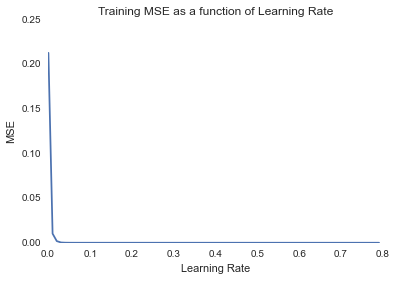

In [152]:
plt.plot(shrink,mse)
plt.title('Training MSE as a function of Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('MSE')

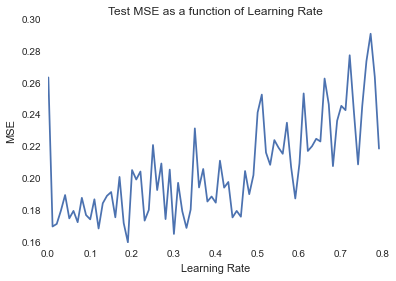

In [153]:
plt.plot(shrink,mse_test)
plt.title('Test MSE as a function of Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('MSE')

In [190]:
best_test_lambda = pd.concat([pd.DataFrame(shrink),pd.DataFrame(mse_test)],axis=1)
best_test_lambda.columns = ['learning_rate','mse']
print best_test_lambda['mse'].argmin()

print best_test_lambda[19:20]
## we see lowest mse is 0.160281 and corresponds to learning_rate = 0.191

19
    learning_rate       mse
19          0.191  0.160281


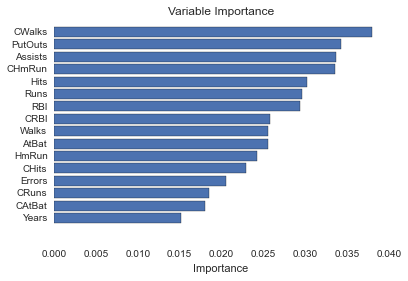

In [201]:
## which predictors are most important

## first, refit to get model from best learning rate
params = {'n_estimators': 1000, 'min_samples_split': 1,
          'learning_rate': 0.191, 'loss': 'ls'}
gbt_best = GradientBoostingRegressor(**params)
gbt_best.fit(X_train,y_train)

feature_importance = gbt_best.feature_importances_
sorted_indices = np.argsort(feature_importance)
y_pos = range(len(feature_importance))
plt.barh(y_pos,feature_importance[sorted_indices],align='center')
plt.yticks(y_pos,X_train.columns[sorted_indices])
plt.xlabel('Importance')
plt.title('Variable Importance')
plt.show()

## From the plot, we see that CWalks is the variable with the highest importance, followed by PutOuts, Assists, and CHmRun


In [214]:
## use OLS and Ridge or Lasso models to compare test MSE's
linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)  # i do not know why python can't do this
lin_pred = linear_regression.predict(X_test)
lin_mse = np.mean((lin_pred-y_test)**2)

###################################
## my apologies, but I didn't have any more time to research why this part simply won't run in python. Every similar example I've found shows this system working.


AttributeError: 'float' object has no attribute 'dtype'

In [207]:
## use bagging (random forest)

rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, max_features='sqrt', oob_score=True,
                            n_jobs=1, verbose=0)
rf.fit(X_train,y_train)

rf_mse = np.mean((rf.predict(X_test)-y_test)**2)
rf_mse

## with the Random Forest, our test MSE is much higher than that acheived using the Boosted model above.

0.2610405066412896